<a href="https://colab.research.google.com/github/AbhishekDutt/kaggle-fake-news/blob/master/fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data and Embeddings:

In [ ]:
%%bash
if [ ! -f data/fake-news.zip ]; then
  wget https://github.com/AbhishekDutt/kaggle-fake-news/raw/master/data/fake-news.zip -P data/
fi
if [ ! -f data/train.csv ]; then
  unzip data/fake-news.zip -d data/
fi
if [ ! -f model/GoogleNews-vectors-negative300.bin.gz ]; then
  wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz -P model/
fi
if [ ! -f model/glove.6B.100d.txt ]; then
  wget https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz -P model/
  gunzip model/glove.6B.100d.txt.gz
fi
pip install Cython  # needed for using more workers in Word2Vec

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.model_selection import PredefinedSplit
import gensim
from gensim.models import FastText, Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing import text, sequence
import tensorflow as tf
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  # Works on CPU and single GPU.
  strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train, valid = train_test_split(data, test_size=0.2)
train = train.copy()
valid = valid.copy()

# Exploratory Data Analysis:

## Util Functions

In [5]:
def get_null_info(data, text, ax):
  null_columns=data.columns[data.isnull().any()]
  str = "\nTotal count: {:,}".format(len(data))
  str += "\nNULL count: {:,}".format(len(data[data.isnull().any(axis=1)]))
  str += "\nNULL %: {:.2%}".format(len(data[data.isnull().any(axis=1)])/len(data)) 
  data.isnull().sum().plot(kind="bar", title="NULL by column "+ text, ax=ax);
  ax.text(0.5,-0.35, str, size=12, ha="center",  transform=ax.transAxes)
  

In [6]:
def plot_class_hist(data, text, ax):
  ax = data["label"].value_counts().plot(kind="bar", title="Row counts by class ("+text+")", ax=ax);
  for p in ax.patches:
      width, height = p.get_width(), p.get_height()
      ax.annotate('{:.2%}'.format(height/len(data)), (p.get_x()+0.5*width, p.get_y()+height*0.9), ha='center', fontsize=15,
  color='white')

In [7]:
def box_plot(data, col, ax):
  bx = data.boxplot(column=[col], by='label', ax=ax, grid=False);
  m1 = data.groupby(['label'])[col].median().values
  m2 = data.groupby(['label'])[col].mean().values
  mL1 = ["{:,}".format(int(n)) for n in np.round(m1, 0)]
  mL2 = ["{:,}".format(int(n)) for n in np.round(m2, 0)]
  for tick in range(len(bx.get_xticklabels())):
    bx.text(tick+1.1, m1[tick], mL1[tick], color='b', weight='semibold')
    # bx.text(tick+1.1, m1[tick], mL2[tick], color='b', weight='semibold')
    

## Check for Null Data

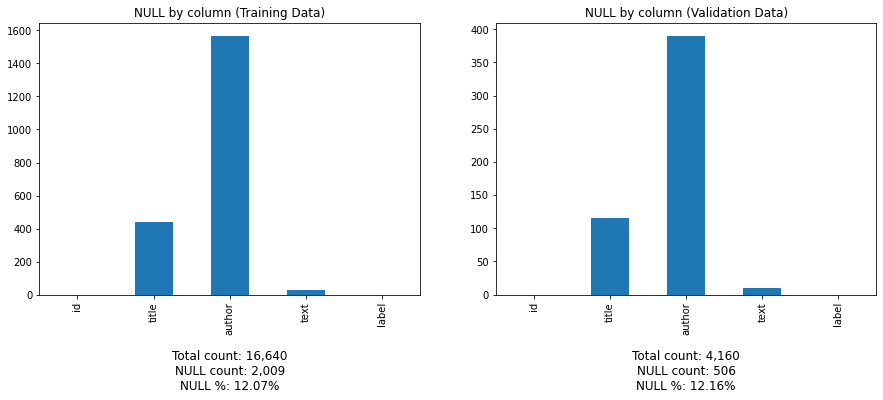

In [8]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 2, 1)
get_null_info(train, "(Training Data)", ax);
ax=fig.add_subplot(1, 2, 2)
get_null_info(valid, "(Validation Data)", ax);

## Class balance:

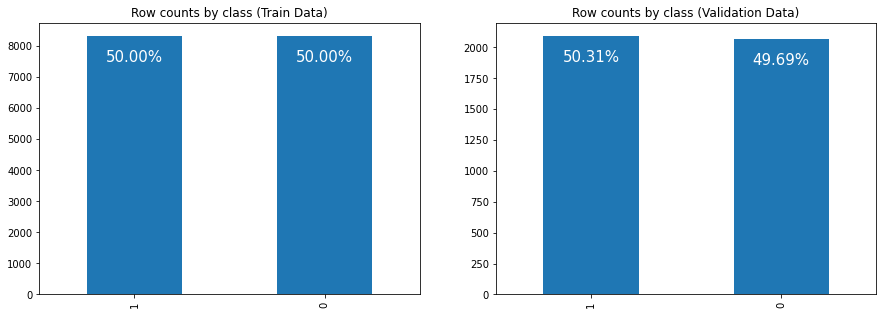

In [9]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 2, 1)
plot_class_hist(train, "Train Data", ax=ax)
ax=fig.add_subplot(1, 2, 2)
plot_class_hist(valid, "Validation Data", ax=ax)

## Word Counts by Class:

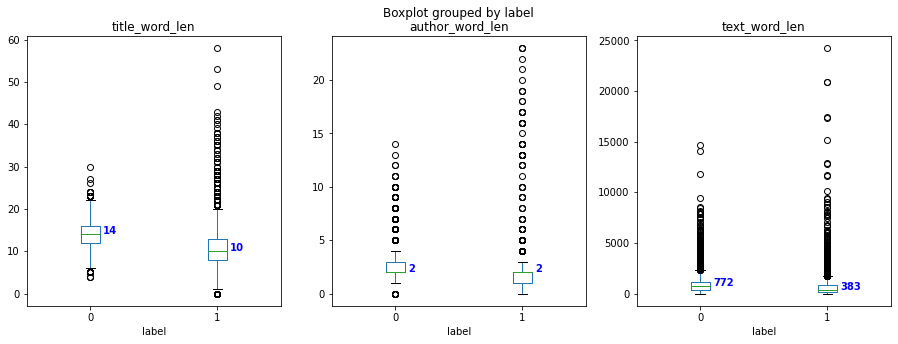

In [10]:
train['title_word_len'] = train['title'].fillna("").str.split().apply(lambda x: len(x))
train['author_word_len'] = train['author'].fillna("").str.split().apply(lambda x: len(x))
train['text_word_len'] = train['text'].fillna("").str.split().apply(lambda x: len(x))

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 3, 1)
box_plot(train, 'title_word_len', ax)
ax=fig.add_subplot(1, 3, 2)
box_plot(train, 'author_word_len', ax)
ax=fig.add_subplot(1, 3, 3)
box_plot(train, 'text_word_len', ax)

## Character counts by Class:

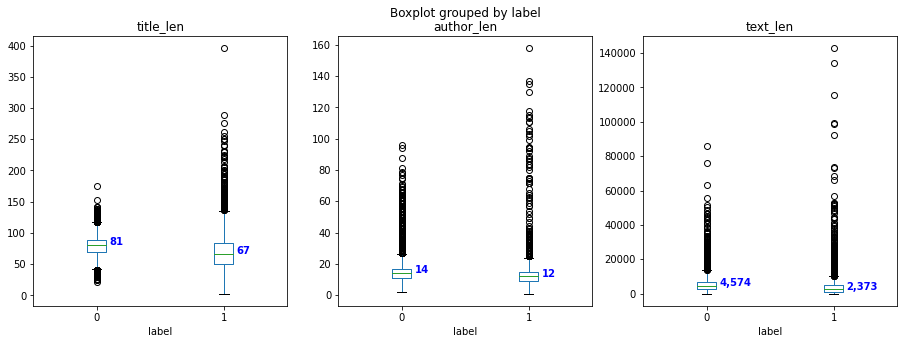

In [11]:
train['title_len'] = train['title'].str.len()
train['author_len'] = train['author'].str.len()
train['text_len'] = train['text'].str.len()

fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1, 3, 1)
box_plot(train, 'title_len', ax)
ax=fig.add_subplot(1, 3, 2)
box_plot(train, 'author_len', ax)
ax=fig.add_subplot(1, 3, 3)
box_plot(train, 'text_len', ax)

# Preprocessing:

## Combine all text fields into one:

In [12]:
train['all_text'] = train['title'].fillna("") + train['author'].fillna("") + train['text'].fillna("")
valid['all_text'] = valid['title'].fillna("") + valid['author'].fillna("") + valid['text'].fillna("")

In [13]:
x_train = train['all_text']
x_valid = valid['all_text']
y_train = train['label']
y_valid = valid['label']

# Models:

## LSTM model with GloVe:

In [ ]:
%%time
# Using keras tokenizer
max_len = 1500
token = text.Tokenizer(num_words=None)
token.fit_on_texts(list(x_train))
x_train_seq = token.texts_to_sequences(x_train)
x_valid_seq = token.texts_to_sequences(x_valid)

# Zero pad the sequences
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_valid_pad = sequence.pad_sequences(x_valid_seq, maxlen=max_len)
word_index = token.word_index

In [ ]:
%%time
# Load the GloVe vectors in a dictionary:
WORD_VEC_SIZE = 100
embeddings_index = {}
f = open('model/glove.6B.100d.txt', 'r', encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, WORD_VEC_SIZE))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

400000it [00:11, 34816.10it/s]

Found 400000 word vectors.
CPU times: user 11.2 s, sys: 558 ms, total: 11.8 s
Wall time: 11.5 s


In [ ]:
%%time
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

with strategy.scope():
  # A simple LSTM with glove embeddings and one dense layer
  model = Sequential()
  model.add(Embedding(len(word_index) + 1, WORD_VEC_SIZE, weights=[embedding_matrix], input_length=max_len, trainable=False))
  model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 100)         22894300  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 22,974,801
Trainable params: 80,501
Non-trainable params: 22,894,300
_________________________________________________________________
CPU times: user 966 ms, sys: 556 ms, total: 1.52 s
Wall time: 9.12 s


In [ ]:
model.fit(x_train_pad, y_train, batch_size=64*strategy.num_replicas_in_sync);

260/260 [==============================] - 489s 2s/step - loss: 0.4781 - accuracy: 0.7703


In [ ]:
%%time
scores = model.predict(x_valid_pad)
valid_acc = accuracy_score(y_valid, scores>0.5, normalize=True)
print("Valid acc: "+ str(valid_acc))

# Word Vectors:

In [14]:
SEQUENCE_LENGTH = 500

## Count Vectors:

In [15]:
%%time
# Count Vectors
from sklearn.feature_extraction.text import CountVectorizer
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 1), stop_words = 'english')

ctv.fit( x_train )
x_train_ctv = ctv.transform( x_train )
x_valid_ctv = ctv.transform( x_valid )

svd = TruncatedSVD(n_components=SEQUENCE_LENGTH)
svd.fit( x_train_ctv )
x_train_ctv_svd = svd.transform(x_train_ctv)
x_valid_ctv_svd = svd.transform(x_valid_ctv)

CPU times: user 1min 49s, sys: 6.38 s, total: 1min 55s
Wall time: 1min 33s


## TF-IDF:

In [34]:
%%time
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
        strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')
tfv.fit( x_train )
x_train_tfv = tfv.transform(x_train)
x_valid_tfv = tfv.transform(x_valid)

svd = TruncatedSVD(n_components=SEQUENCE_LENGTH)
svd.fit( x_train_tfv )
x_train_tfv_svd = svd.transform(x_train_tfv)
x_valid_tfv_svd = svd.transform(x_valid_tfv)

CPU times: user 5min 59s, sys: 15.5 s, total: 6min 15s
Wall time: 5min 21s


## Word2Vec

In [38]:
%%time
# word2vec
x_train_tmp = x_train.apply(lambda x: x.lower().split())
x_valid_tmp = x_valid.apply(lambda x: x.lower().split())

WORD2VEC_SIZE = 300
# vectorizer = Word2Vec(x_train, size=WORD2VEC_SIZE, window=5, min_count=5, workers=4, sg=1, iter=5)
vectorizer = gensim.models.KeyedVectors.load_word2vec_format('model/GoogleNews-vectors-negative300.bin.gz', binary=True)

# Convert a sentence to a word2vec vector
def to_vector(sentence):
  words = [word for word in sentence if word in vectorizer.vocab]
  if words:
    return np.mean(vectorizer[words], axis=0)
  else:
    return np.zeros(WORD2VEC_SIZE)
    
x_train_w2v = np.array([to_vector(sentence) for sentence in x_train_tmp])
x_valid_w2v = np.array([to_vector(sentence) for sentence in x_valid_tmp])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 2min 48s, sys: 4.26 s, total: 2min 52s
Wall time: 2min 53s


## FastText:

In [ ]:
 %%time
# FastText (Skipped: Takes long time)
# x_train_tmp = x_train.apply(lambda x: x.split())
# x_valid_tmp = x_valid.apply(lambda x: x.split())

# FASTTEXT_SIZE = 300
# vectorizer = FastText(size=FASTTEXT_SIZE, window=20, min_count=3, sg=1, iter=5)
# vectorizer.build_vocab(x_train_tmp)
# vectorizer.train(x_train_tmp, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

# def to_vector(sentence):
#   words = [word for word in sentence if word in vectorizer.wv.vocab]
#   if words:
#     return np.mean(vectorizer.wv[words], axis=0)
#   else:
#     return np.zeros(FASTTEXT_SIZE)
    
# x_train_fasttext = np.array([to_vector(sentence) for sentence in x_train_tmp])
# x_valid_fasttext = np.array([to_vector(sentence) for sentence in x_valid_tmp])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


## Grid Search CV:

In [37]:
def grid_search(train_x, train_y, valid_x, valid_y, data_source):

  estimators = [
    LogisticRegression(penalty='none', C=1, solver='lbfgs', max_iter=100, n_jobs=-1),
    KNeighborsClassifier(n_jobs=-1),
    SVC(C=1.0, probability=False),
    RandomForestClassifier(),
    XGBClassifier(objective='binary:logistic', eval_metric='error')
  ] 

  parameters_list = [
    {'penalty' : ['l1', 'l2', 'none'], 'C' : [1, 0.1, 0.01], 'solver' : ['liblinear']},
    # {'n_neighbors':range(1, 21, 3), 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan', 'minkowski']},
    {'n_neighbors': [1, 10]},
    {'kernel':['poly', 'rbf'], 'C':[1.0, 0.01], 'gamma':['scale']},
    # {'kernel':['poly', 'rbf'], 'C':[50, 0.01], 'gamma':['scale']},
    {'n_estimators':[10, 50, 100], 'max_features':['sqrt', 'log2']},
    # {'n_estimators':[50], 'max_features':['sqrt', 'log2']},
    {'max_depth':[2, 6]}
  ]

  results = []

  for i in range(len(estimators)):
    grid = GridSearchCV(estimator = estimators[i], 
                        param_grid = parameters_list[i], 
                        n_jobs = -1, cv = 2, scoring = 'accuracy',
                        verbose=1)
    grid.fit(train_x, train_y)
    print("==================")
    print(grid.best_params_)
    print("CV acc: " + str(grid.best_score_))
    y_train_pred = results[i]['best_estimator_'].predict(train_x)
    train_acc = accuracy_score(train_y, y_train_pred, normalize=True)
    print("Train acc: " + str(train_acc))
    y_valid_pred = results[i]['best_estimator_'].predict(valid_x)
    valid_acc = accuracy_score(valid_y, y_valid_pred, normalize=True)
    print("Valid acc: " + str(valid_acc))
    results.append({
      "data": data_source,
      "best_params": grid.best_params_, 
      "best_cv_score": grid.best_score_,
      "best_train_score": train_acc,
      "best_valid_score": valid_acc,
      "best_estimator_": grid.best_estimator_
    })
    print("==================")
  
  return results


In [29]:
%%time
# Count Vector:
result = []
result = result + grid_search(x_train_ctv_svd, y_train, x_valid_ctv_svd, y_valid, "CountVector")
pickle.dump( result, open( "result.pkl", "wb" ) )

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   19.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
CV acc: 0.9385216346153846
Train acc: 0.9513822115384616
Valid acc: 0.9423076923076923
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.9min finished


{'n_neighbors': 10}
CV acc: 0.848798076923077
Train acc: 0.8911658653846154
Valid acc: 0.8692307692307693
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.4min finished


{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
CV acc: 0.9212740384615384
Train acc: 0.9528846153846153
Valid acc: 0.9408653846153846
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   55.2s finished


{'max_features': 'sqrt', 'n_estimators': 100}
CV acc: 0.8682692307692308
Train acc: 1.0
Valid acc: 0.8961538461538462
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.0min finished


{'max_depth': 6}
CV acc: 0.9109375
Train acc: 0.9944110576923076
Valid acc: 0.9201923076923076


In [36]:
%%time
# TF-IDF:
result = pickle.load( open( "result.pkl", "rb" ) )
result = result + grid_search(x_train_tfv_svd, y_train, x_valid_tfv_svd, y_valid, "TFIDF")
pickle.dump( result, open( "result.pkl", "wb" ) )

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
CV acc: 0.9589543269230769
Train acc: 0.9665865384615384
Valid acc: 0.9603365384615384
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.7min finished


{'n_neighbors': 1}
CV acc: 0.9182091346153847
Train acc: 1.0
Valid acc: 0.9252403846153846
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.7min finished


{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
CV acc: 0.9775841346153846
Train acc: 0.991045673076923
Valid acc: 0.9764423076923077
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


{'max_features': 'sqrt', 'n_estimators': 100}
CV acc: 0.9447716346153846
Train acc: 1.0
Valid acc: 0.9475961538461538
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.0min finished


{'max_depth': 6}
CV acc: 0.9533653846153847
Train acc: 0.9989783653846154
Valid acc: 0.959375


In [39]:
%%time
# Word2Vec:
result = pickle.load( open( "result.pkl", "rb" ) )
result = result + grid_search(x_train_w2v, y_train, x_valid_w2v, y_valid, "Word2Vec")
pickle.dump( result, open( "result.pkl", "wb" ) )

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
CV acc: 0.8429086538461539
Train acc: 0.8615384615384616
Valid acc: 0.8485576923076923
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  2.4min finished


{'n_neighbors': 1}
CV acc: 0.8088341346153847
Train acc: 1.0
Valid acc: 0.83125
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.9min finished


{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
CV acc: 0.8739182692307692
Train acc: 0.896875
Valid acc: 0.8786057692307693
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   49.5s finished


{'max_features': 'sqrt', 'n_estimators': 100}
CV acc: 0.8355769230769231
Train acc: 1.0
Valid acc: 0.8456730769230769
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.2min finished


{'max_depth': 6}
CV acc: 0.8636418269230769
Train acc: 0.9753004807692308
Valid acc: 0.8680288461538461
CPU times: user 5min 40s, sys: 1.88 s, total: 5min 42s
Wall time: 11min 39s


In [ ]:
%%time
# FastText:
# result = pickle.load( open( "result.pkl", "rb" ) )
# result = result + grid_search(x_train_fasttext, y_train, x_valid_fasttext, y_valid, "FastText")
# pickle.dump( result, open( "result.pkl", "wb" ) )

# Test Data Classification:

## Get best model:

In [43]:
result = pickle.load(open("result.pkl", "rb"))
model = max(result, key = lambda x: x['best_score'])

## Preprocess Test Data:

In [ ]:
test['all_text'] = test['title'].fillna("") + test['author'].fillna("") + test['text'].fillna("")
x_test = test['all_text']
y_test = test['label']

# Best model is TF-IDF:
x_test_tfv = tfv.transform(x_test)
x_test_tfv_svd = svd.transform(x_test_tfv)

## Predict:

In [44]:
y_test_pred = model["best_estimator_"].predict(x_test_tfv_svd)

{'best_estimator_': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'best_params': {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},
 'best_score': 0.9775841346153846}